# Visualization of an HPL trace

In [1]:
import io
import zipfile
import pandas
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

def read_csv(archive_name, csv_name, columns=None, filter_func=lambda x: x):
    archive = zipfile.ZipFile(archive_name)
    df= pandas.read_csv(io.BytesIO(filter_func(archive.read(csv_name))), names=columns)
    df.columns = df.columns.str.strip()
    return df

def filter_pajeng(pajeng_output, keep):
    lines = pajeng_output.split(b'\n')
    lines = [l for l in lines if l.startswith(keep.encode())]
    return b'\n'.join(lines)

def _read_paje_state(archive_name, csv_name, has_msg_size=False, replace_func=('MPI', 'MPI')):
    columns=['type', 'rank', 'container', 'start', 'end', 'duration', 'level', 'function']
    if has_msg_size:
        columns.append('tmp')
    df = read_csv(archive_name, csv_name, columns=columns, filter_func=lambda x: filter_pajeng(x, 'State'))
    df['function'] = df['function'].str.replace(*replace_func).str.strip()  # for some reason Simgrid uses PMPI_Wait and not MPI_Wait
    df['msg_size'] = -1
    if has_msg_size:
        df.loc[df['function'].isin(['MPI_Recv', 'MPI_Send', 'MPI_Isend', 'MPI_Irecv']), 'msg_size'] = df['tmp']
        df['msg_size'] = df['msg_size'].astype(int)
    df['rank'] = df['rank'].str.slice(5).astype(int)  # changing 'rank42' into 42
    return df

def read_mpi_state(archive_name, csv_name):
    df = _read_paje_state(archive_name, csv_name, True)
    return df

def read_smpi_state(archive_name, csv_name):
    df = _read_paje_state(archive_name, csv_name, True, ('PMPI', 'MPI'))
    df['rank'] = -df['rank']  # in SMPI, we have 'rank-42' and not 'rank42', so there remains a - that we should remove
    return df

def read_smpi_link(archive_name, csv_name):
    df = read_csv(archive_name, csv_name,
                  columns=['type', 'level', 'container', 'start', 'end', 'duration', 'commType', 'src', 'dst', 'msg_size'],
                  filter_func=lambda x: filter_pajeng(x, 'Link'))
    df['src'] = df['src'].str.slice(6).astype(int)  # changing 'rank42' into 42
    df['dst'] = df['dst'].str.slice(6).astype(int)  # changing 'rank42' into 42
#    df['remote'] = (df['src'] // 32) != (df['dst'] // 32)
    return df

def read_archive(archive_name, mode, drop_func=['MPI_Comm_rank', 'MPI_Comm_size', 'MPI_Comm_split', 'MPI_Comm_free', 'MPI_Init', 'MPI_Finalize']):
    assert mode in ('reality', 'simgrid')
    print('# Mode: %s' % mode)
    blas_col = ['file', 'line', 'function', 'rank', 'timestamp', 'duration', 'm', 'n', 'k']
    blas_trace = read_csv(archive_name, 'trace_blas_0.csv', columns=blas_col)
    print('\tBLAS trace: %6d lines' % len(blas_trace))
    blas_trace['start'] = blas_trace.timestamp
    blas_trace['end'] = blas_trace.timestamp + blas_trace.duration
    blas_trace['kind'] = 'BLAS'
    blas_trace['function'] = blas_trace['function'].str.strip()
    if mode == 'reality':
        mpi_trace = read_mpi_state(archive_name, 'trace_mpi_0.csv')
    else:
        mpi_trace = read_smpi_state(archive_name, 'trace_mpi_0.csv')
    print('\tMPI  trace: %6d lines' % len(mpi_trace))
    mpi_trace = mpi_trace[['function', 'start', 'end', 'rank', 'msg_size']]
    mpi_trace['kind'] = 'MPI'
    df = pandas.concat([blas_trace, mpi_trace])
    df['mode'] = mode
    df['rank+1'] = df['rank'] + 1
    old_len = len(df)
    df = df[~df['function'].str.strip().isin(drop_func)]
    print('Removed %d events with functions in %s' % (old_len-len(df), ', '.join(drop_func)))
    if mode == 'reality':
        df_links = None
    else:
        df_links = read_smpi_link(archive_name, 'trace_mpi_0.csv')
    return df, df_links

reality_file = 'grenoble_2019-01-15_1840494.zip'

trace_reality, link_reality = read_archive(reality_file, 'reality')
trace_reality.head()

# Mode: reality
	BLAS trace: 119978 lines
	MPI  trace: 156922 lines
Removed 15904 events with functions in MPI_Comm_rank, MPI_Comm_size, MPI_Comm_split, MPI_Comm_free, MPI_Init, MPI_Finalize


,duration,end,file,function,k,kind,line,m,msg_size,n,rank,start,timestamp,mode,rank+1
0,0.000045,5.657025,../HPL_dlocmax.c,idamax,NaN,BLAS,125.0,31360.0,NaN,NaN,0,5.656980,5.656980,reality,1
1,0.000008,5.657049,../HPL_pdmxswp.c,dcopy,NaN,BLAS,165.0,128.0,NaN,NaN,0,5.657041,5.657041,reality,1
2,0.000001,5.657052,../HPL_pdmxswp.c,dcopy,NaN,BLAS,167.0,128.0,NaN,NaN,0,5.657051,5.657051,reality,1
3,0.000034,5.710558,../HPL_pdpancrT.c,dscal,NaN,BLAS,214.0,31359.0,NaN,NaN,0,5.710524,5.710524,reality,1
4,0.000137,5.710697,../HPL_pdpancrT.c,dgemv,NaN,BLAS,234.0,31359.0,NaN,1.0,0,5.710560,5.710560,reality,1


In [2]:
trace_reality[trace_reality['kind'] == 'MPI'].head()

,duration,end,file,function,k,kind,line,m,msg_size,n,rank,start,timestamp,mode,rank+1
7,NaN,0.001569,NaN,MPI_Send,NaN,MPI,NaN,NaN,4.0,NaN,99,0.001548,NaN,reality,100
10,NaN,0.014622,NaN,MPI_Recv,NaN,MPI,NaN,NaN,4.0,NaN,99,0.001571,NaN,reality,100
13,NaN,0.014797,NaN,MPI_Send,NaN,MPI,NaN,NaN,8.0,NaN,99,0.014794,NaN,reality,100
16,NaN,0.025921,NaN,MPI_Recv,NaN,MPI,NaN,NaN,8.0,NaN,99,0.014798,NaN,reality,100
19,NaN,0.025939,NaN,MPI_Recv,NaN,MPI,NaN,NaN,8.0,NaN,99,0.025922,NaN,reality,100


In [3]:
trace_reality[trace_reality['kind'] == 'BLAS'].head()

,duration,end,file,function,k,kind,line,m,msg_size,n,rank,start,timestamp,mode,rank+1
0,0.000045,5.657025,../HPL_dlocmax.c,idamax,NaN,BLAS,125.0,31360.0,NaN,NaN,0,5.656980,5.656980,reality,1
1,0.000008,5.657049,../HPL_pdmxswp.c,dcopy,NaN,BLAS,165.0,128.0,NaN,NaN,0,5.657041,5.657041,reality,1
2,0.000001,5.657052,../HPL_pdmxswp.c,dcopy,NaN,BLAS,167.0,128.0,NaN,NaN,0,5.657051,5.657051,reality,1
3,0.000034,5.710558,../HPL_pdpancrT.c,dscal,NaN,BLAS,214.0,31359.0,NaN,NaN,0,5.710524,5.710524,reality,1
4,0.000137,5.710697,../HPL_pdpancrT.c,dgemv,NaN,BLAS,234.0,31359.0,NaN,1.0,0,5.710560,5.710560,reality,1


## Checking the parameters

In [4]:
read_csv(reality_file, 'exp.csv')

,matrix_size,block_size,proc_p,proc_q,pfact,rfact,bcast,depth,swap,mem_align,process_per_node,thread_per_process
0,250000,128,8,32,1,2,2,1,0,8,32,1


In [5]:
for kind in trace_reality['kind'].unique():
    df = trace_reality[trace_reality['kind'] == kind]
    print(kind, df.start.min(), df.end.max())

BLAS 5.65698 27.784599567999997
MPI 0.000171 27.830228


## Removing the initialization and the finalization in the traces

In [6]:
def split(df):
    return [df[df['rank'] == rank] for rank in df['rank'].unique()]

def crop(df, func_name):
    func_calls = df[df['function'] == func_name]
    assert len(func_calls) == 2
    start = func_calls['end'].min()
    end = func_calls['start'].max()
    return df[(df['start'] > start) & (df['end'] < end)]

def crop_all(df, func_name):
    df_ranks = [crop(tmp_df, func_name) for tmp_df in split(df)]
    df = pandas.concat(df_ranks)
    min_time = df['start'].min()
    df['start'] -= min_time
    df['end'] -= min_time
    return df

In [7]:
trace_reality = crop_all(trace_reality, 'MPI_Bcast')
print(trace_reality['start'].min(), trace_reality['end'].max())

0.0 13.377665000000002


## Displaying the traces

In [8]:
def plot(df, wrap=['mode', 'kind']):
    gc = ggplot(df) + geom_rect(aes(xmin='start', xmax='end', ymin='rank', ymax='rank+1',fill='function')) + facet_wrap(wrap) + theme_bw()
    return gc

In [9]:
def plot_bounded(df, start, end, ranks, wrap=['mode', 'kind']):
    df = df[df['rank'].isin(ranks)]
    df = df[(df['end'] >= start) & (df['start'] <= end)].copy()
    df.loc[df['start'] < start, 'start'] = start
    df.loc[df['end'] > end, 'end'] = end
    return plot(df, wrap) + xlim(start, end) + ggtitle('Events between %.1fs and %.1fs for ranks in %s' % (start, end, ranks))

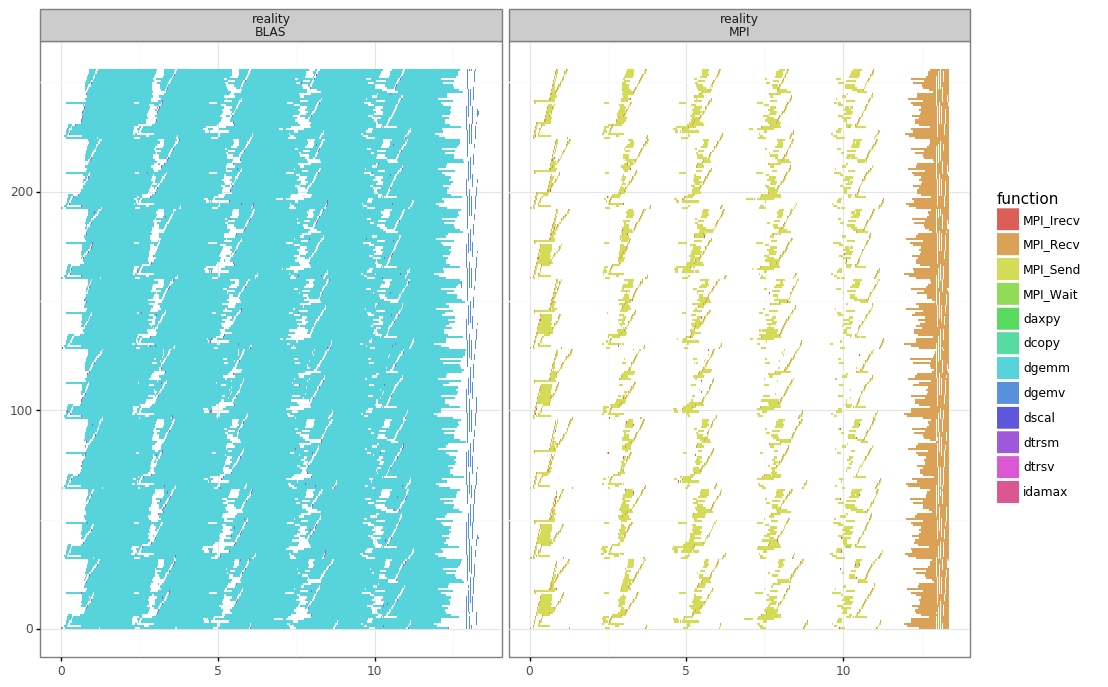

<ggplot: (-9223363271116417392)>

In [10]:
plot(trace_reality)

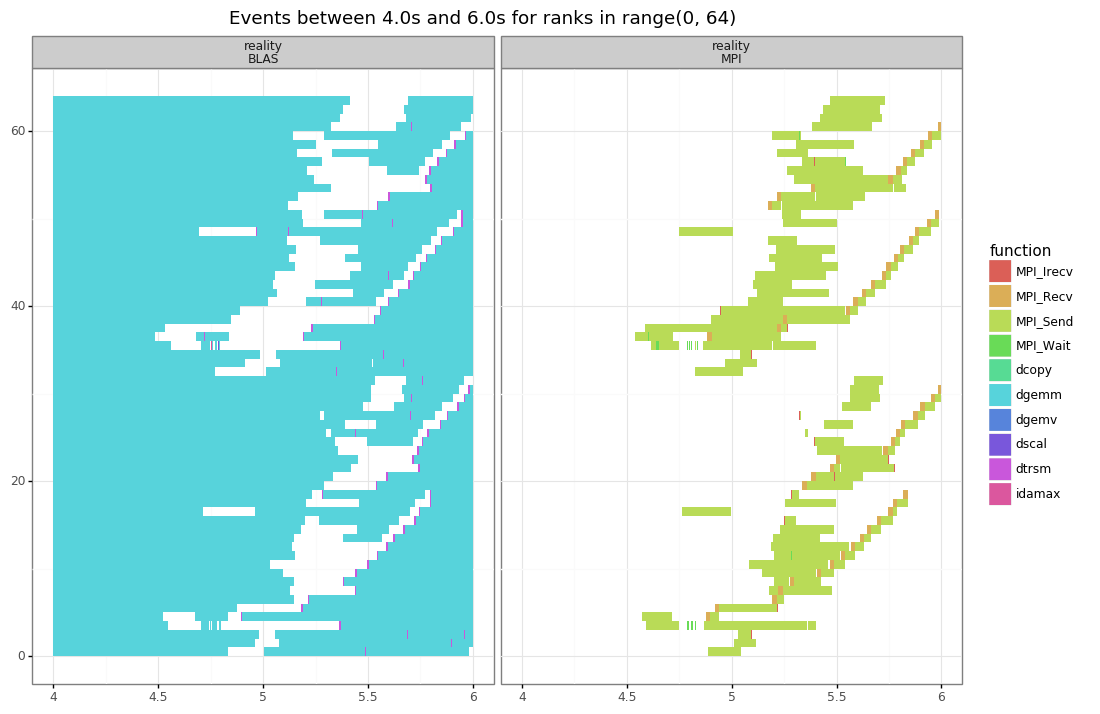

<ggplot: (8765706955752)>

In [11]:
plot_bounded(trace_reality, 4, 6, range(64))

## Counting the number of events

In [12]:
trace_reality.groupby('function')[['rank']].count()

,rank
function,
MPI_Irecv,22392
MPI_Recv,30762
MPI_Send,53152
MPI_Wait,22392
daxpy,15596
dcopy,20180
dgemm,17236
dgemv,33902
dscal,5916


## Plotting the durations

In [13]:
blas = trace_reality[trace_reality['kind'] == 'BLAS'].copy()
blas['size_product'] = -1
blas.loc[blas.function == 'dgemm', 'size_product'] = blas.m * blas.n * blas.k
blas.loc[blas.function == 'dtrsm', 'size_product'] = blas.m * blas.n**2
blas.loc[blas.function == 'dtrsv', 'size_product'] = blas.m**2
for func in ['dgemv']:
    blas.loc[blas.function == func, 'size_product'] = blas.m * blas.n
for func in ['daxpy', 'dcopy', 'dscal', 'idamax']:
    blas.loc[blas.function == func, 'size_product'] = blas.m

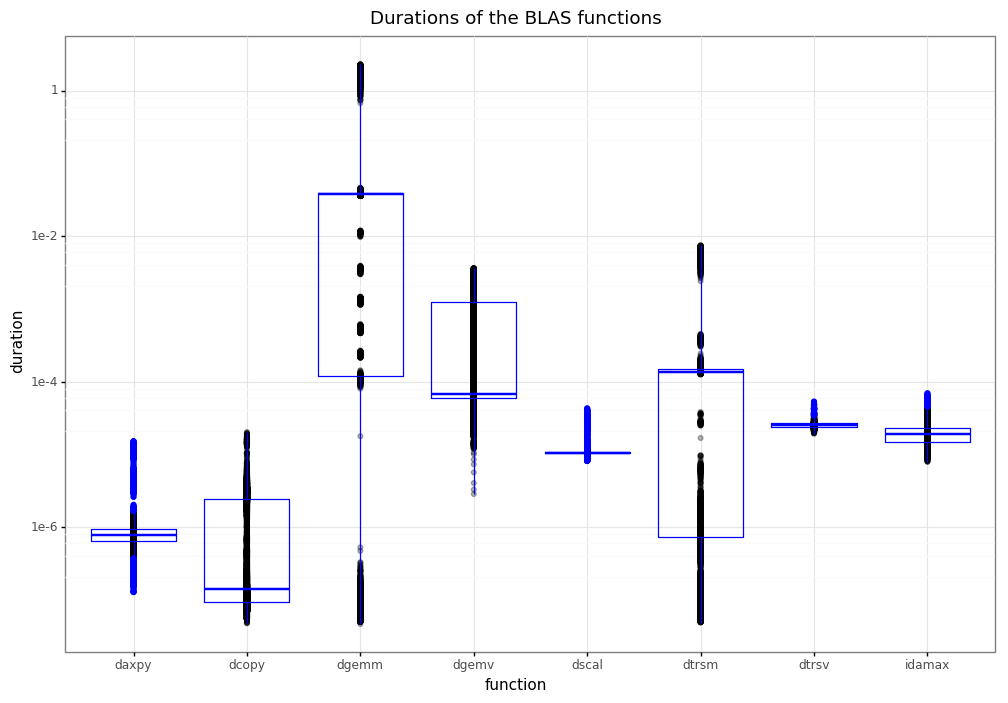

<ggplot: (8765743436534)>

In [14]:
plot = ggplot(blas, aes(x='function', y='duration')) + geom_point(alpha=0.3) + scale_y_log10()
plot = plot + theme_bw() + ggtitle('Durations of the BLAS functions') + geom_boxplot(alpha=0, color='blue')
plot

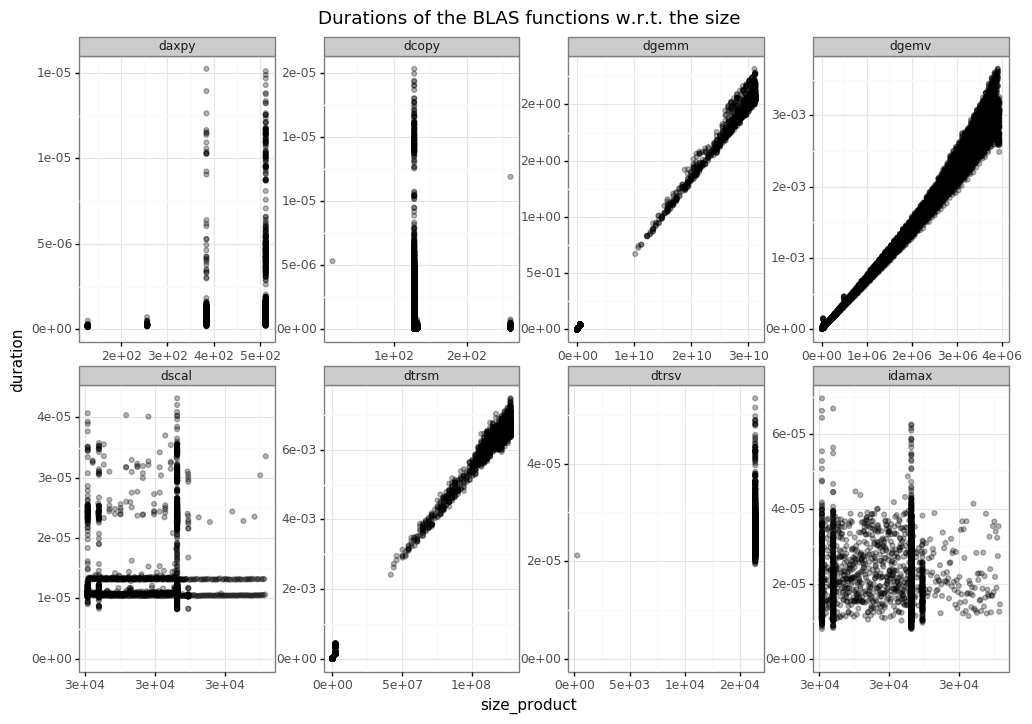

<ggplot: (8765706642173)>

In [15]:
my_label = lambda l: ['%.0e' % x for x in l]
plot = ggplot(blas, aes(x='size_product', y='duration')) + geom_point(alpha=0.3)
plot = plot + facet_wrap('function', scales='free', nrow=2) + theme_bw() + ggtitle('Durations of the BLAS functions w.r.t. the size')
plot = plot + theme(subplots_adjust={'hspace':0.15, 'wspace':0.25})  # the subplots_adjust is to fix a display bug...
plot = plot + scale_y_continuous(labels=my_label) + scale_x_continuous(labels=my_label) + expand_limits(y=0)
plot